In [1]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from collections import Counter
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import asyncio
import urllib.request

#Check if GPU is fried yet
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [2]:
data = np.load('flatland_train.npz')
X = data['X']
y = data['y']
y[y != 0] -= 2    # Correct labels so that triangle is mapped to class 1
X = X.reshape(X.shape[0], 50, 50, 1) / 255

In [3]:
X.shape

(10000, 50, 50, 1)

In [4]:
Counter(y)

Counter({2.0: 1868, 4.0: 1761, 3.0: 2137, 1.0: 2853, 0.0: 1381})

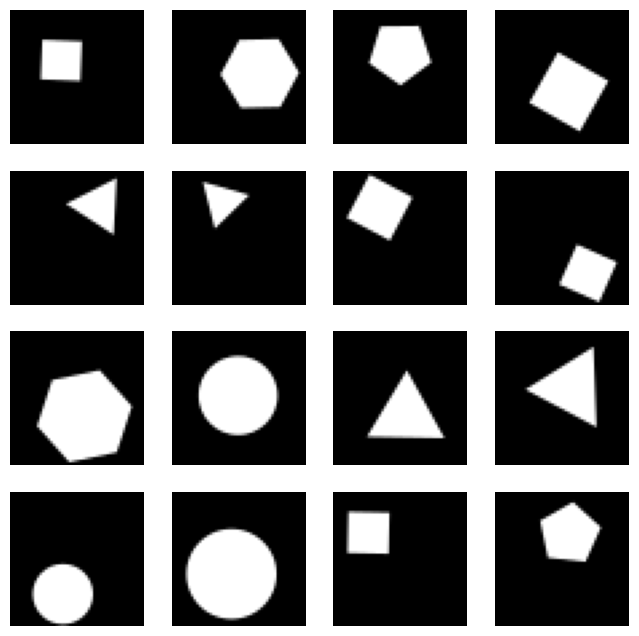

In [5]:
#Original data visualisation

data_generator = ImageDataGenerator()
for X_batch, y_batch in data_generator.flow(X, y, batch_size = 16, shuffle = False):
    fig, ax = plt.subplots(4, 4, figsize=(8, 8))
    for i in range(4):
        for j in range(4):
            ax[i][j].axis('off')
            ax[i][j].imshow(X_batch[i*4 + j].reshape(50, 50), cmap = 'gray')
    plt.show()
    break

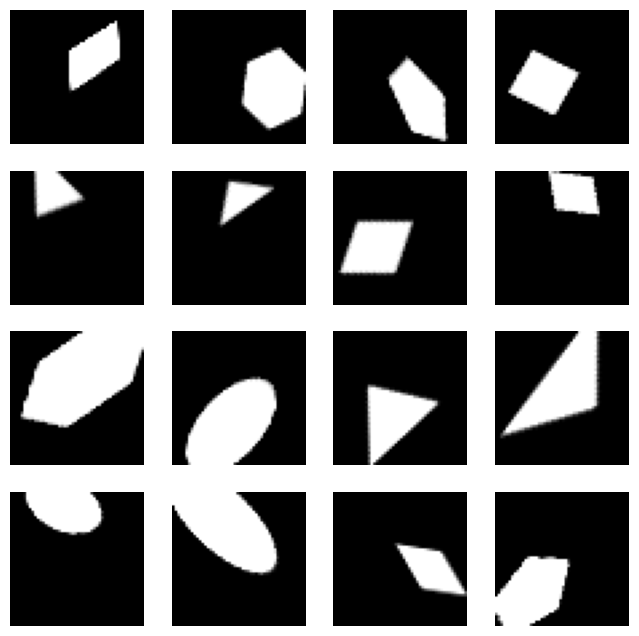

In [6]:
#Data augmentation visualisation

data_generator = ImageDataGenerator(
    rotation_range = 90,
    zoom_range = 0.2,
    shear_range = 45,
    horizontal_flip = 0.5,
    vertical_flip = 0.5,
    height_shift_range = 0.2,
    width_shift_range = 0.2,
    channel_shift_range = 0.9,
    validation_split = 0.2
)
data_generator.fit(X)
for X_batch, y_batch in data_generator.flow(X, y, batch_size = 16, shuffle = False):
    fig, ax = plt.subplots(4, 4, figsize=(8, 8))
    for i in range(4):
        for j in range(4):
            ax[i][j].axis('off')
            ax[i][j].imshow(X_batch[i*4 + j].reshape(50, 50), cmap = 'gray')
    plt.show()
    break

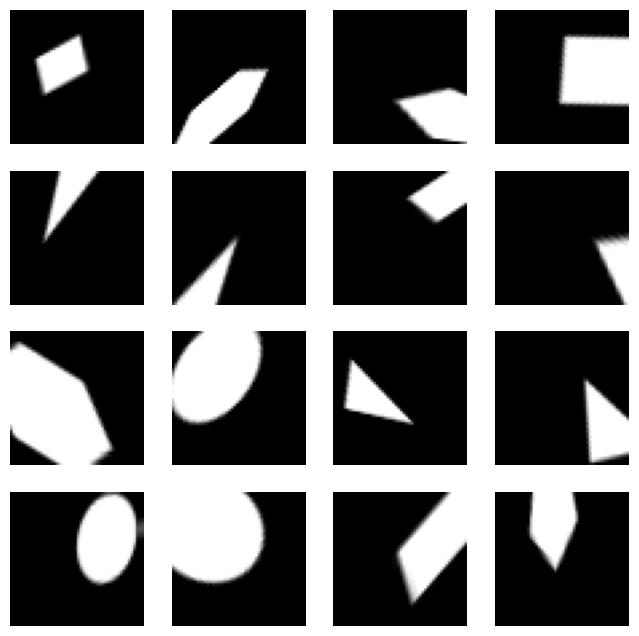

In [7]:
#Train for the worst

data_generator = ImageDataGenerator(
    rotation_range = 180,
    zoom_range = 0.5,
    shear_range = 70,
    horizontal_flip = 0.5,
    vertical_flip = 0.5,
    height_shift_range = 0.25,
    width_shift_range = 0.25,
    validation_split = 0.2
)
data_generator.fit(X)
for X_batch, y_batch in data_generator.flow(X, y, batch_size = 16, shuffle = False):
    fig, ax = plt.subplots(4, 4, figsize=(8, 8))
    for i in range(4):
        for j in range(4):
            ax[i][j].axis('off')
            ax[i][j].imshow(X_batch[i*4 + j].reshape(50, 50), cmap = 'gray')
    plt.show()
    break

In [ ]:
#99.48% on advanced model

inp = keras.layers.Input(shape = (50, 50, 1));
out = keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=[50, 50, 1])(inp);
out = keras.layers.MaxPooling2D(pool_size=(2, 2))(out);
out = keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu')(out);
out = keras.layers.MaxPooling2D(pool_size=(2, 2))(out);
out = keras.layers.Conv2D(128, kernel_size=(3, 3), activation='relu')(out);
out = keras.layers.MaxPooling2D(pool_size=(2, 2))(out);
out = keras.layers.Conv2D(512, kernel_size=(3, 3), activation='relu')(out);
out = keras.layers.MaxPooling2D(pool_size=(2, 2))(out);
out = keras.layers.Flatten()(out);
out = keras.layers.Dropout(0.4)(out);
out = keras.layers.Dense(512, activation = 'relu')(out);
out = keras.layers.Dropout(0.6)(out);
out = keras.layers.Dense(512, activation = 'relu')(out);
out = keras.layers.Dropout(0.6)(out);
out = keras.layers.Dense(512, activation = 'relu')(out);
out = keras.layers.Dropout(0.6)(out);
out = keras.layers.Dense(128, activation = 'relu')(out);
out = keras.layers.Dropout(0.6)(out);
out = keras.layers.Dense(5, activation = 'softmax')(out);


checkpoint = keras.callbacks.ModelCheckpoint(filepath = '99.48_model_17.6MB.h5', monitor = 'val_loss', save_best_only = True, mode = 'min');

model = keras.models.Model(inputs = inp, outputs = out);
model.compile(optimizer = keras.optimizers.Adam(learning_rate = 3e-4), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy']);
model.summary();

hist = model.fit(data_generator.flow(X, y, batch_size = 100, subset = 'training'),
                 validation_data = data_generator.flow(X, y, batch_size = 10, subset = 'validation'),
                 steps_per_epoch = len(X)*0.8/100, epochs = 200, callbacks = [checkpoint]);

In [ ]:
#Funny squiggles

pd.DataFrame(hist.history).plot()

In [ ]:
#Fail

inp = keras.layers.Input(shape = (50, 50, 1));
out = keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding = 'same', input_shape=[50, 50, 1])(inp);
out = keras.layers.MaxPooling2D(pool_size=(2, 2))(out);
out = keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding = 'same')(out);
out = keras.layers.MaxPooling2D(pool_size=(2, 2))(out);
out = keras.layers.Conv2D(128, kernel_size=(3, 3), activation='relu', padding = 'same')(out);
out = keras.layers.MaxPooling2D(pool_size=(2, 2))(out);
out = keras.layers.Conv2D(128, kernel_size=(3, 3), activation='relu', padding = 'same')(out);
out = keras.layers.MaxPooling2D(pool_size=(2, 2))(out);
out = keras.layers.Flatten()(out);
out = keras.layers.Dropout(0.4)(out);
out = keras.layers.Dense(1024, activation = 'relu')(out);
out = keras.layers.Dropout(0.6)(out);
out = keras.layers.Dense(1024, activation = 'relu')(out);
out = keras.layers.Dropout(0.6)(out);
out = keras.layers.Dense(1024, activation = 'relu')(out);
out = keras.layers.Dropout(0.6)(out);
out = keras.layers.Dense(1024, activation = 'relu')(out);
out = keras.layers.Dropout(0.6)(out);
out = keras.layers.Dense(1024, activation = 'relu')(out);
out = keras.layers.Dropout(0.6)(out);
out = keras.layers.Dense(1024, activation = 'relu')(out);
out = keras.layers.Dropout(0.6)(out);
out = keras.layers.Dense(1024, activation = 'relu')(out);
out = keras.layers.Dropout(0.6)(out);
out = keras.layers.Dense(512, activation = 'relu')(out);
out = keras.layers.Dropout(0.6)(out);
out = keras.layers.Dense(5, activation = 'softmax')(out);


checkpoint = keras.callbacks.ModelCheckpoint(filepath = 'failed_model.h5', monitor = 'val_loss', save_best_only = True, mode = 'min');

model = keras.models.Model(inputs = inp, outputs = out);
model.compile(optimizer = keras.optimizers.Adam(learning_rate = 3e-4), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy']);
model.summary();

hist = model.fit(data_generator.flow(X, y, batch_size = 100, subset = 'training'),
                 validation_data = data_generator.flow(X, y, batch_size = 10, subset = 'validation'),
                 steps_per_epoch = len(X)*0.8/100, epochs = 200, callbacks = [checkpoint]);

In [ ]:
#More funny squiggles

pd.DataFrame(hist.history).plot()

In [ ]:
#Model that got 100% on advanced, 23MB

inp = keras.layers.Input(shape = (50, 50, 1));
out = keras.layers.Conv2D(32, kernel_size=(5, 5), padding = 'same', input_shape=[50, 50, 1])(inp);
out = keras.layers.Activation("relu")(out);
out = keras.layers.MaxPooling2D(pool_size=(2, 2))(out);
out = keras.layers.Conv2D(64, kernel_size=(4, 4), padding = 'same')(out);
out = keras.layers.Activation("relu")(out);
out = keras.layers.MaxPooling2D(pool_size=(2, 2))(out);
for i in range(3):
    out = keras.layers.Conv2D(128, kernel_size=(3, 3), padding = 'same')(out);
    out = keras.layers.Activation("relu")(out);
out = keras.layers.MaxPooling2D(pool_size=(2, 2))(out);
for i in range(3):
    out = keras.layers.Conv2D(128, kernel_size=(3, 3), padding = 'same')(out);
    out = keras.layers.Activation("relu")(out);
out = keras.layers.MaxPooling2D(pool_size=(2, 2))(out);
out = keras.layers.Flatten()(out);
out = keras.layers.Dropout(0.3)(out);
out = keras.layers.Dense(1000, activation = 'relu')(out);
out = keras.layers.Dropout(0.3)(out);
out = keras.layers.Dense(5, activation = 'softmax')(out);


checkpoint = keras.callbacks.ModelCheckpoint(filepath = '100_model_23MB.h5', monitor = 'val_loss', save_best_only = True, mode = 'min');

model = keras.models.Model(inputs = inp, outputs = out);
model.compile(optimizer = keras.optimizers.Adam(learning_rate = 3e-4), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy']);
model.summary();

hist = model.fit(data_generator.flow(X, y, batch_size = 100, subset = 'training'),
                 validation_data = data_generator.flow(X, y, batch_size = 10, subset = 'validation'),
                 steps_per_epoch = len(X)*0.8/100, epochs = 200, callbacks = [checkpoint]);

In [ ]:
#Even more funny squiggles

pd.DataFrame(hist.history).plot()

In [ ]:
#Load the winner, continue training and save all epochs for... reasons

model = tf.keras.models.load_model('100_model_23MB.h5');
checkpoint = keras.callbacks.ModelCheckpoint(filepath = '23MB_epochs\{epoch:d}model.h5', monitor = 'val_loss', save_best_only = False, mode = 'min');
hist = model.fit(data_generator.flow(X, y, batch_size = 100, subset = 'training'),
                 validation_data = data_generator.flow(X, y, batch_size = 10, subset = 'validation'),
                 steps_per_epoch = len(X)*0.8/100, epochs = 20, callbacks = [checkpoint]);

In [ ]:
#Here's a little lesson in trickery

def background(f):
    def wrapped(*args, **kwargs):
        return asyncio.get_event_loop().run_in_executor(None, f, *args, **kwargs)
    return wrapped

@background
def brute_force(x):
    url = 'https://us-central1-aiprimer.cloudfunctions.net/flatland?model_link=https://github.com/DDomjosa/flatland/blob/main/23MB_epochs/'+str(x)+'model.h5?raw=true';
    uf = urllib.request.urlopen(url)
    html = uf.read()
    print('Epoch = ' + str(x) + ':\n\n' + html.decode("utf-8") + '\n')
    
for i in range(1, 21):
    brute_force(i)

In [ ]:
#100% on advanced, 673KB
#Needs A LOT of training to reach 100%

inp = keras.layers.Input(shape = (50, 50, 1));
out = keras.layers.Conv2D(16, kernel_size=(5, 5), activation = 'relu', padding = 'same', input_shape=[50, 50, 1])(inp);
out = keras.layers.Conv2D(16, kernel_size=(5, 5), activation = 'relu', padding = 'same')(out);
out = keras.layers.Conv2D(16, kernel_size=(5, 5), activation = 'relu', padding = 'same')(out);
out = keras.layers.MaxPooling2D(pool_size=(2, 2))(out);
out = keras.layers.Conv2D(16, kernel_size=(3, 3), activation = 'relu', padding = 'same')(out);
out = keras.layers.Conv2D(16, kernel_size=(3, 3), activation = 'relu', padding = 'same')(out);
out = keras.layers.Conv2D(16, kernel_size=(3, 3), activation = 'relu', padding = 'same')(out);
out = keras.layers.MaxPooling2D(pool_size=(2, 2))(out);
out = keras.layers.Conv2D(32, kernel_size=(3, 3), activation = 'relu', padding = 'same')(out);
out = keras.layers.Conv2D(32, kernel_size=(3, 3), activation = 'relu', padding = 'same')(out);
out = keras.layers.Conv2D(32, kernel_size=(3, 3), activation = 'relu', padding = 'same')(out);
out = keras.layers.MaxPooling2D(pool_size=(2, 2))(out);
out = keras.layers.Flatten()(out);
out = keras.layers.Dropout(0.3)(out);
out = keras.layers.Dense(5, activation = 'softmax')(out);


checkpoint = keras.callbacks.ModelCheckpoint(filepath = '100_model_673KB.h5', monitor = 'val_loss', save_best_only = True, mode = 'min');

model = keras.models.Model(inputs = inp, outputs = out);
model.compile(optimizer = keras.optimizers.Adam(learning_rate = 3e-4), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy']);
model.summary();

hist = model.fit(data_generator.flow(X, y, batch_size = 100, subset = 'training'),
                 validation_data = data_generator.flow(X, y, batch_size = 10, subset = 'validation'),
                 steps_per_epoch = len(X)*0.8/100, epochs = 2500, callbacks = [checkpoint]);

In [ ]:
#The funniest of squiggles

pd.DataFrame(hist.history).plot()

In [ ]:
model = tf.keras.models.load_model('100_model_673KB.h5');
checkpoint = keras.callbacks.ModelCheckpoint(filepath = '673KB_epochs\{epoch:d}model.h5', monitor = 'val_loss', save_best_only = False, mode = 'min');
hist = model.fit(data_generator.flow(X, y, batch_size = 100, subset = 'training'),
                 validation_data = data_generator.flow(X, y, batch_size = 10, subset = 'validation'),
                 steps_per_epoch = len(X)*0.8/100, epochs = 20, callbacks = [checkpoint]);

In [ ]:
def background(f):
    def wrapped(*args, **kwargs):
        return asyncio.get_event_loop().run_in_executor(None, f, *args, **kwargs)
    return wrapped

@background
def brute_force(x):
    url = 'https://us-central1-aiprimer.cloudfunctions.net/flatland?model_link=https://github.com/DDomjosa/flatland/blob/main/673KB_epochs/'+str(x)+'model.h5?raw=true';
    uf = urllib.request.urlopen(url)
    html = uf.read()
    print('Epoch = ' + str(x) + ':\n\n' + html.decode("utf-8") + '\n')
    
for i in range(1, 21):
    brute_force(i)

In [9]:
inp = keras.layers.Input(shape = (50, 50, 1));
out = keras.layers.Conv2D(16, kernel_size=(3, 3), activation = 'relu', padding = 'same', input_shape=[50, 50, 1])(inp);
out = keras.layers.Conv2D(16, kernel_size=(3, 3), activation = 'relu', padding = 'same')(out);
out = keras.layers.MaxPooling2D(pool_size=(2, 2))(out);
out = keras.layers.Conv2D(16, kernel_size=(3, 3), activation = 'relu', padding = 'same')(out);
out = keras.layers.Conv2D(16, kernel_size=(3, 3), activation = 'relu', padding = 'same')(out);
out = keras.layers.MaxPooling2D(pool_size=(2, 2))(out);
out = keras.layers.Conv2D(16, kernel_size=(3, 3), activation = 'relu', padding = 'same')(out);
out = keras.layers.Conv2D(16, kernel_size=(3, 3), activation = 'relu', padding = 'same')(out);
out = keras.layers.Conv2D(16, kernel_size=(3, 3), activation = 'relu', padding = 'same')(out);
out = keras.layers.MaxPooling2D(pool_size=(2, 2))(out);
out = keras.layers.Conv2D(32, kernel_size=(2, 2), activation = 'relu', padding = 'same')(out);
out = keras.layers.Conv2D(32, kernel_size=(2, 2), activation = 'relu', padding = 'same')(out);
out = keras.layers.Conv2D(32, kernel_size=(2, 2), activation = 'relu', padding = 'same')(out);
out = keras.layers.MaxPooling2D(pool_size=(2, 2))(out);
out = keras.layers.Flatten()(out);
out = keras.layers.Dropout(0.4)(out);
out = keras.layers.Dense(5, activation = 'softmax')(out);


checkpoint = keras.callbacks.ModelCheckpoint(filepath = 'model.h5', monitor = 'val_loss', save_best_only = True, mode = 'min');

model = keras.models.Model(inputs = inp, outputs = out);
model.compile(optimizer = keras.optimizers.Adam(learning_rate = 3e-4), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy']);
model.summary();

hist = model.fit(data_generator.flow(X, y, batch_size = 100, subset = 'training'),
                 validation_data = data_generator.flow(X, y, batch_size = 10, subset = 'validation'),
                 steps_per_epoch = len(X)*0.8/100, epochs = 500, callbacks = [checkpoint]);

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 50, 50, 1)]       0         
                                                                 
 conv2d_10 (Conv2D)          (None, 50, 50, 16)        160       
                                                                 
 conv2d_11 (Conv2D)          (None, 50, 50, 16)        2320      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 25, 25, 16)       0         
 2D)                                                             
                                                                 
 conv2d_12 (Conv2D)          (None, 25, 25, 16)        2320      
                                                                 
 conv2d_13 (Conv2D)          (None, 25, 25, 16)        2320      
                                                           

Epoch 37/500
80/80 [==============================] - 4s 46ms/step - loss: 0.7902 - accuracy: 0.6996 - val_loss: 0.7661 - val_accuracy: 0.7160
Epoch 38/500
80/80 [==============================] - 4s 49ms/step - loss: 0.7707 - accuracy: 0.7129 - val_loss: 0.7079 - val_accuracy: 0.7350
Epoch 39/500
80/80 [==============================] - 4s 49ms/step - loss: 0.8146 - accuracy: 0.6810 - val_loss: 0.7222 - val_accuracy: 0.7320
Epoch 40/500
80/80 [==============================] - 4s 49ms/step - loss: 0.7956 - accuracy: 0.6954 - val_loss: 0.7832 - val_accuracy: 0.6875
Epoch 41/500
80/80 [==============================] - 4s 48ms/step - loss: 0.7723 - accuracy: 0.7019 - val_loss: 0.7210 - val_accuracy: 0.7305
Epoch 42/500
80/80 [==============================] - 4s 49ms/step - loss: 0.7699 - accuracy: 0.7049 - val_loss: 0.7471 - val_accuracy: 0.7155
Epoch 43/500
80/80 [==============================] - 4s 48ms/step - loss: 0.7563 - accuracy: 0.7178 - val_loss: 0.7087 - val_accuracy: 0.7380

80/80 [==============================] - 4s 47ms/step - loss: 0.6282 - accuracy: 0.7735 - val_loss: 0.5983 - val_accuracy: 0.7880
Epoch 95/500
80/80 [==============================] - 4s 49ms/step - loss: 0.6267 - accuracy: 0.7620 - val_loss: 0.5780 - val_accuracy: 0.7915
Epoch 96/500
80/80 [==============================] - 4s 48ms/step - loss: 0.6269 - accuracy: 0.7674 - val_loss: 0.5722 - val_accuracy: 0.7825
Epoch 97/500
80/80 [==============================] - 4s 50ms/step - loss: 0.6325 - accuracy: 0.7719 - val_loss: 0.5407 - val_accuracy: 0.8040
Epoch 98/500
80/80 [==============================] - 4s 47ms/step - loss: 0.6240 - accuracy: 0.7708 - val_loss: 0.5859 - val_accuracy: 0.7760
Epoch 99/500
80/80 [==============================] - 4s 48ms/step - loss: 0.6164 - accuracy: 0.7781 - val_loss: 0.5537 - val_accuracy: 0.7950
Epoch 100/500
80/80 [==============================] - 4s 48ms/step - loss: 0.6081 - accuracy: 0.7780 - val_loss: 0.5490 - val_accuracy: 0.8040
Epoch 101/5

80/80 [==============================] - 4s 47ms/step - loss: 0.5753 - accuracy: 0.7931 - val_loss: 0.5399 - val_accuracy: 0.8100
Epoch 152/500
80/80 [==============================] - 4s 47ms/step - loss: 0.5699 - accuracy: 0.7910 - val_loss: 0.5209 - val_accuracy: 0.8205
Epoch 153/500
80/80 [==============================] - 4s 47ms/step - loss: 0.5803 - accuracy: 0.7895 - val_loss: 0.5207 - val_accuracy: 0.8065
Epoch 154/500
80/80 [==============================] - 4s 47ms/step - loss: 0.5562 - accuracy: 0.8053 - val_loss: 0.5097 - val_accuracy: 0.8220
Epoch 155/500
80/80 [==============================] - 4s 47ms/step - loss: 0.5569 - accuracy: 0.8026 - val_loss: 0.4947 - val_accuracy: 0.8175
Epoch 156/500
80/80 [==============================] - 4s 46ms/step - loss: 0.5524 - accuracy: 0.8018 - val_loss: 0.5626 - val_accuracy: 0.7765
Epoch 157/500
80/80 [==============================] - 4s 48ms/step - loss: 0.5934 - accuracy: 0.7806 - val_loss: 0.5417 - val_accuracy: 0.8000
Epoch 

Epoch 208/500
80/80 [==============================] - 4s 49ms/step - loss: 0.5187 - accuracy: 0.8133 - val_loss: 0.4509 - val_accuracy: 0.8350
Epoch 209/500
80/80 [==============================] - 4s 49ms/step - loss: 0.5131 - accuracy: 0.8226 - val_loss: 0.4938 - val_accuracy: 0.8155
Epoch 210/500
80/80 [==============================] - 4s 50ms/step - loss: 0.5065 - accuracy: 0.8231 - val_loss: 0.4557 - val_accuracy: 0.8345
Epoch 211/500
80/80 [==============================] - 4s 52ms/step - loss: 0.5149 - accuracy: 0.8171 - val_loss: 0.5055 - val_accuracy: 0.8190
Epoch 212/500
80/80 [==============================] - 4s 48ms/step - loss: 0.5206 - accuracy: 0.8130 - val_loss: 0.4498 - val_accuracy: 0.8430
Epoch 213/500
80/80 [==============================] - 4s 49ms/step - loss: 0.5059 - accuracy: 0.8193 - val_loss: 0.5096 - val_accuracy: 0.8190
Epoch 214/500
80/80 [==============================] - 4s 48ms/step - loss: 0.5198 - accuracy: 0.8165 - val_loss: 0.4726 - val_accuracy:

Epoch 265/500
80/80 [==============================] - 4s 47ms/step - loss: 0.4812 - accuracy: 0.8293 - val_loss: 0.4150 - val_accuracy: 0.8510
Epoch 266/500
80/80 [==============================] - 4s 51ms/step - loss: 0.4731 - accuracy: 0.8378 - val_loss: 0.4714 - val_accuracy: 0.8165
Epoch 267/500
80/80 [==============================] - 4s 51ms/step - loss: 0.4691 - accuracy: 0.8376 - val_loss: 0.4488 - val_accuracy: 0.8390
Epoch 268/500
80/80 [==============================] - 4s 49ms/step - loss: 0.4866 - accuracy: 0.8310 - val_loss: 0.4321 - val_accuracy: 0.8435
Epoch 269/500
80/80 [==============================] - 4s 50ms/step - loss: 0.4973 - accuracy: 0.8273 - val_loss: 0.4583 - val_accuracy: 0.8365
Epoch 270/500
80/80 [==============================] - 4s 48ms/step - loss: 0.4934 - accuracy: 0.8275 - val_loss: 0.4381 - val_accuracy: 0.8400
Epoch 271/500
80/80 [==============================] - 4s 52ms/step - loss: 0.4747 - accuracy: 0.8370 - val_loss: 0.3883 - val_accuracy:

Epoch 322/500
80/80 [==============================] - 4s 48ms/step - loss: 0.4740 - accuracy: 0.8358 - val_loss: 0.4086 - val_accuracy: 0.8575
Epoch 323/500
80/80 [==============================] - 4s 48ms/step - loss: 0.4793 - accuracy: 0.8319 - val_loss: 0.4140 - val_accuracy: 0.8580
Epoch 324/500
80/80 [==============================] - 4s 48ms/step - loss: 0.4423 - accuracy: 0.8456 - val_loss: 0.4177 - val_accuracy: 0.8490
Epoch 325/500
80/80 [==============================] - 4s 47ms/step - loss: 0.4502 - accuracy: 0.8461 - val_loss: 0.4249 - val_accuracy: 0.8510
Epoch 326/500
80/80 [==============================] - 4s 49ms/step - loss: 0.4509 - accuracy: 0.8438 - val_loss: 0.3943 - val_accuracy: 0.8545
Epoch 327/500
80/80 [==============================] - 4s 49ms/step - loss: 0.4536 - accuracy: 0.8436 - val_loss: 0.3900 - val_accuracy: 0.8655
Epoch 328/500
80/80 [==============================] - 4s 48ms/step - loss: 0.4495 - accuracy: 0.8431 - val_loss: 0.4156 - val_accuracy:

Epoch 379/500
80/80 [==============================] - 4s 48ms/step - loss: 0.4347 - accuracy: 0.8531 - val_loss: 0.3934 - val_accuracy: 0.8570
Epoch 380/500
80/80 [==============================] - 4s 48ms/step - loss: 0.4413 - accuracy: 0.8508 - val_loss: 0.3847 - val_accuracy: 0.8665
Epoch 381/500
80/80 [==============================] - 4s 47ms/step - loss: 0.4424 - accuracy: 0.8459 - val_loss: 0.4081 - val_accuracy: 0.8575
Epoch 382/500
80/80 [==============================] - 4s 48ms/step - loss: 0.4217 - accuracy: 0.8545 - val_loss: 0.3657 - val_accuracy: 0.8710
Epoch 383/500
80/80 [==============================] - 4s 47ms/step - loss: 0.4320 - accuracy: 0.8523 - val_loss: 0.3964 - val_accuracy: 0.8715
Epoch 384/500
80/80 [==============================] - 4s 48ms/step - loss: 0.4339 - accuracy: 0.8548 - val_loss: 0.3609 - val_accuracy: 0.8800
Epoch 385/500
80/80 [==============================] - 4s 49ms/step - loss: 0.4167 - accuracy: 0.8608 - val_loss: 0.3567 - val_accuracy:

Epoch 436/500
80/80 [==============================] - 4s 47ms/step - loss: 0.4142 - accuracy: 0.8628 - val_loss: 0.3794 - val_accuracy: 0.8685
Epoch 437/500
80/80 [==============================] - 4s 47ms/step - loss: 0.4038 - accuracy: 0.8685 - val_loss: 0.3641 - val_accuracy: 0.8720
Epoch 438/500
80/80 [==============================] - 4s 50ms/step - loss: 0.4148 - accuracy: 0.8565 - val_loss: 0.3589 - val_accuracy: 0.8820
Epoch 439/500
80/80 [==============================] - 4s 48ms/step - loss: 0.4315 - accuracy: 0.8523 - val_loss: 0.3939 - val_accuracy: 0.8575
Epoch 440/500
80/80 [==============================] - 4s 49ms/step - loss: 0.4148 - accuracy: 0.8591 - val_loss: 0.3635 - val_accuracy: 0.8725
Epoch 441/500
80/80 [==============================] - 4s 50ms/step - loss: 0.4144 - accuracy: 0.8598 - val_loss: 0.3932 - val_accuracy: 0.8630
Epoch 442/500
80/80 [==============================] - 4s 50ms/step - loss: 0.4167 - accuracy: 0.8584 - val_loss: 0.3421 - val_accuracy:

Epoch 493/500
80/80 [==============================] - 4s 49ms/step - loss: 0.4201 - accuracy: 0.8604 - val_loss: 0.4709 - val_accuracy: 0.8295
Epoch 494/500
80/80 [==============================] - 4s 50ms/step - loss: 0.4013 - accuracy: 0.8669 - val_loss: 0.3777 - val_accuracy: 0.8675
Epoch 495/500
80/80 [==============================] - 4s 48ms/step - loss: 0.4216 - accuracy: 0.8589 - val_loss: 0.3619 - val_accuracy: 0.8785
Epoch 496/500
80/80 [==============================] - 4s 48ms/step - loss: 0.3965 - accuracy: 0.8698 - val_loss: 0.3551 - val_accuracy: 0.8730
Epoch 497/500
80/80 [==============================] - 4s 48ms/step - loss: 0.3954 - accuracy: 0.8655 - val_loss: 0.3496 - val_accuracy: 0.8865
Epoch 498/500
80/80 [==============================] - 4s 51ms/step - loss: 0.3876 - accuracy: 0.8766 - val_loss: 0.3971 - val_accuracy: 0.8560
Epoch 499/500
80/80 [==============================] - 4s 49ms/step - loss: 0.4000 - accuracy: 0.8600 - val_loss: 0.3557 - val_accuracy:

In [ ]:
hist = model.fit(data_generator.flow(X, y, batch_size = 100, subset = 'training'),
                 validation_data = data_generator.flow(X, y, batch_size = 10, subset = 'validation'),
                 steps_per_epoch = len(X)*0.8/100, epochs = 2000, callbacks = [checkpoint]);

In [10]:
model = tf.keras.models.load_model('model.h5');
checkpoint = keras.callbacks.ModelCheckpoint(filepath = '409KB_epochs\{epoch:d}model.h5', monitor = 'val_loss', save_best_only = False, mode = 'min');
hist = model.fit(data_generator.flow(X, y, batch_size = 100, subset = 'training'),
                 validation_data = data_generator.flow(X, y, batch_size = 10, subset = 'validation'),
                 steps_per_epoch = len(X)*0.8/100, epochs = 20, callbacks = [checkpoint]);

Epoch 1/20
80/80 [==============================] - 5s 51ms/step - loss: 0.4029 - accuracy: 0.8648 - val_loss: 0.3432 - val_accuracy: 0.8825
Epoch 2/20
80/80 [==============================] - 4s 50ms/step - loss: 0.4021 - accuracy: 0.8635 - val_loss: 0.4166 - val_accuracy: 0.8515
Epoch 3/20
80/80 [==============================] - 4s 48ms/step - loss: 0.4035 - accuracy: 0.8665 - val_loss: 0.3764 - val_accuracy: 0.8715
Epoch 4/20
80/80 [==============================] - 4s 48ms/step - loss: 0.3935 - accuracy: 0.8691 - val_loss: 0.3451 - val_accuracy: 0.8825
Epoch 5/20
80/80 [==============================] - 4s 51ms/step - loss: 0.4140 - accuracy: 0.8635 - val_loss: 0.3750 - val_accuracy: 0.8745
Epoch 6/20
80/80 [==============================] - 4s 51ms/step - loss: 0.4235 - accuracy: 0.8625 - val_loss: 0.3571 - val_accuracy: 0.8770
Epoch 7/20
80/80 [==============================] - 4s 49ms/step - loss: 0.3981 - accuracy: 0.8618 - val_loss: 0.3945 - val_accuracy: 0.8610
Epoch 8/20
80

In [ ]:
def background(f):
    def wrapped(*args, **kwargs):
        return asyncio.get_event_loop().run_in_executor(None, f, *args, **kwargs)
    return wrapped

@background
def brute_force(x):
    url = 'https://us-central1-aiprimer.cloudfunctions.net/flatland?model_link=https://github.com/DDomjosa/flatland/blob/main/409KB_epochs/'+str(x)+'model.h5?raw=true';
    uf = urllib.request.urlopen(url)
    html = uf.read()
    print('Epoch = ' + str(x) + ':\n\n' + html.decode("utf-8") + '\n')
    
for i in range(1, 21):
    brute_force(i)